<a href="https://colab.research.google.com/github/kristinyim/CynthiasCastle/blob/master/hw6_kimy6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# Kristin Yim (kyim6)
# Deep Learning Fall 2019
# HW 6

In [0]:
# unet.py
# This code is provided for Deep Learning (CS 482/682) Homework 6 practice.
# The network structure is a simplified U-net. You need to finish the last layers
# @Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu
# Modified by Hongtao Wu on Oct 11, 2019 for Fall 2019 Machine Learning: Deep Learning HW6

import torch
import torch.nn as nn
import torch.nn.functional as functional
import numpy as np

In [0]:
# Functions for adding the convolution layer
def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    # Use batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    # No batch normalization
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

In [0]:
# Upsampling
def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

In [0]:
num_classes = 8

In [0]:
# U-Net
class unet(nn.Module):
  def __init__(self, useBN=False):
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1 = add_conv_stage(3, 32, useBN=useBN)
    self.conv2 = add_conv_stage(32, 64, useBN=useBN)
    self.conv3 = add_conv_stage(64, 128, useBN=useBN)
    self.conv4 = add_conv_stage(128, 256, useBN=useBN)
    # Upgrade stages
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)
    # weight initialization
    # You can have your own weight intialization. This is just an example.
    for m in self.modules():
      if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        if m.bias is not None:
          m.bias.data.zero_()

    #TODO: Design your last layer & activations
    self.conv_last = add_conv_stage(32, 3, useBN=useBN)
    self.conv_class = add_conv_stage(3, num_classes, useBN=useBN)
    self.sigmoid = nn.Sigmoid()


  def forward(self, x):
    conv1_out = self.conv1(x) # 3--> 32
    conv2_out = self.conv2(self.max_pool(conv1_out)) # 32 --> 64
    conv3_out = self.conv3(self.max_pool(conv2_out)) # 64 --> 128
    conv4_out = self.conv4(self.max_pool(conv3_out)) # 128 --> 256
    # upsample then conv
    conv4m_out_ = torch.cat((self.upsample43(conv4_out), conv3_out), 1)
    conv3m_out  = self.conv3m(conv4m_out_) # 256 --> 128

    conv3m_out_ = torch.cat((self.upsample32(conv3m_out), conv2_out), 1)
    conv2m_out  = self.conv2m(conv3m_out_) # 128 --> 64

    conv2m_out_ = torch.cat((self.upsample21(conv2m_out), conv1_out), 1)
    conv1m_out  = self.conv1m(conv2m_out_) # 64 --> 32

    #TODO: Design your last layer & activations
    conv_last_out = self.conv_last(conv1m_out) # 32 --> 3
    conv_class_out = self.conv_class(conv_last_out) # 3 --> num_classes
    out = self.sigmoid(conv_class_out)

    return out


In [0]:
# train.py
# This code is provided for Deep Learning class (CS 482/682) Homework 6 practice.
# This is a sketch code for main function. There are some given hyper-parameters insideself.
# You need to finish the design and train your network.
# @Copyright Cong Gao, the Johns Hopkins University, cgao11@jhu.edu
# Modified by Hongtao Wu on Oct 11, 2019 for Fall 2019 Machine Learning: Deep Learning HW6

import os

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import time

In [0]:
######################## Hyperparameters #################################
# Batch size can be changed if it does not match your memory, please state your batch step_size
# in your report.
train_batch_size = 10
validation_batch_size=10
# Please use this learning rate for Prob1(a) and Prob1(b)
learning_rate = 0.001
# This num_epochs is designed for running to be long enough, you need to manually stop or design
# your early stopping method.
num_epochs = 1000

In [9]:
# load the data
from google.colab import drive
drive.mount('/content/drive')
!unzip /content/drive/My\ Drive/Colab\ Notebooks/dl_hw/dl_hw6/segmentation.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive
Archive:  /content/drive/My Drive/Colab Notebooks/dl_hw/dl_hw6/segmentation.zip
   creating: segmentation/
  inflating: segmentation/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/segmentation/
  inflating: __MACOSX/segmentation/._.DS_Store  
   creating: segmentation/test/
   creating: segmentation/test/32/
  inflating: segmentation/test/32/32_mask.png  
   creating: __MACOSX/segmentation/test/
   creating: __MACOSX/segmentation/test/32/
  inflating

In [0]:
# Design your own dataset
class ImageDataset(Dataset):
  def __init__(self,input_dir,transform=None):
    self.input_dir = input_dir
    inputs = []
    masks = []
    for root, _, files in os.walk(input_dir):
      for file in files:
        path = os.path.join(root,file)
        if "input" in path:
          inputs.append(path)
        elif "mask" in path:
          masks.append(path)
    self.inputs_path = inputs
    self.masks_path = masks
    self.transform = transform
#     self.labels = [0,32,64,96,128,160,192,224]
  
  def __len__(self):
    return len(self.inputs_path)
  
  def load_image(self,file_path):
    img = Image.open(file_path)
    img.load()
    data = np.asarray(img, dtype="float32")
    return data
  
#   def one_hot_y(self,y):
#     hot_y = np.zeros((8,y.shape[0],y.shape[1]))
#     for i,label in enumerate(self.labels):
#       hot_y[i] = np.ma.masked_equal(y,label).mask.astype(int)
#     return hot_y
  
  def __getitem__(self, idx):
    # get numpy array
    image = self.load_image(self.inputs_path[idx])
    mask = self.load_image(self.masks_path[idx])

    if self.transform:
      image = self.transform(image)
    # convert y to one hot encodded with 8 channels  
#     mask = self.one_hot_y(mask)
    # to torch; image becomes torch in transform already
    mask = torch.from_numpy(mask)
      
    sample = (image, mask)
    return sample

In [0]:
class DICELoss(nn.Module):
    def __init__(self):
        super(DICELoss, self).__init__()
    
    def forward(self, pred, true):
        true = true.long()
        num_classes = pred.shape[1]
        
        for i, val in enumerate(self.tools_mapping):
            true[true == val] = i
        
        true_1_hot = torch.squeeze(functional.one_hot(true, num_classes = num_classes)).permute(0,3,1,2).contiguous()
        true_1_hot = true_1_hot.type(pred.type())
        true_pos = torch.sum(pred * true_1_hot, dim=(2,3))
        denom = torch.sum(pred + true_1_hot, dim=(2,3))
        dice_loss = (2. * true_pos / (denom + self.epsilon)).mean().view(-1)
        return (1 - dice_loss)
    
    tools_mapping = [0,32,64,96,128,160,192,224]
    epsilon = 1e-7

In [0]:
class DICELoss(nn.Module):
    def __init__(self):
      super(DICELoss, self).__init__()
      self.labels = [0,32,64,96,128,160,192,224]
    
    def one_hot_y(self,y):
#       hot_y = np.zeros((8,y.shape[0],y.shape[1],y.shape[2]))
#       for i,label in enumerate(self.labels):
#         hot_y[i] = np.ma.masked_equal(y,label).mask.astype(int)
#       hot_y = torch.from_numpy(hot_y).permute(1,0,2,3)
      hot_y = torch.zeros(8,y.size()[0],y.size()[1],y.size()[2])
      for i,label in enumerate(self.labels):
        if torch.cuda.is_available():
          hot_y[i] = torch.where(y == torch.tensor([label]).cuda(),torch.tensor([1.]).cuda(),torch.tensor([0.]).cuda())
        else:
          hot_y[i] = torch.where(y == torch.tensor([label]),torch.tensor([1.]),torch.tensor([0.]))
      hot_y = hot_y.permute(1,0,2,3).cuda()
      return hot_y
    
    def forward(self,y_hat,y):
      # covert y into having 8 channels representing the classes
      y = self.one_hot_y(y)
#       if torch.cuda.is_available():
      y.cuda()
      # dice calculation
      numerator = (2*y*y_hat).sum(dim=1)
      denominator = (y+y_hat).sum(dim=1)
      dice = (numerator/denominator).mean()
#       flat_y_hat = torch.flatten(y_hat).double()
#       flat_y = torch.flatten(y).double()
#       numerator = torch.matmul(flat_y_hat,flat_y)
#       print(numerator)
#       print(flat_y)
#       print(flat_y_hat)
#       denominator = np.sum(flat_y_hat) + np.sum(flat_y)
#       print(denominator.shape)
      return 1-dice

In [0]:
model = unet()
if torch.cuda.is_available():
  model = model.cuda()

In [0]:
# train_loader2 = torch.utils.data.DataLoader(train_dataset,batch_size=train_dataset.__len__())
# for (x,y) in train_loader2:
#   x_train_mean = torch.mean(x,[0,1,2])
#   x_train_std = torch.std(x,[0,1,2])
# print(x_train_mean)
# print(x_train_std)

train -----
mean = tensor([122.4148,  76.8673,  86.2640])
std = tensor([49.7471, 42.8070, 47.1072])

In [0]:
# val_loader2 = torch.utils.data.DataLoader(validation_dataset,batch_size=validation_dataset.__len__())
# for (x,y) in val_loader2:
#   x_val_mean = torch.mean(x,[0,1,2])
#   x_val_std = torch.std(x,[0,1,2])
# print(x_val_mean)
# print(x_val_std)

val ----
mean = tensor([122.3141,  77.3933,  87.1767])
std = tensor([49.8322, 43.1028, 47.3641])

In [0]:
# Use your designed dataset for dataloading
test_path = './segmentation/test'
train_path = './segmentation/train'
validation_path = './segmentation/validation'

train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[122.4148,  76.8673,  86.2640],std=[49.7471, 42.8070, 47.1072])
])

val_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[122.3141, 77.3933, 87.1767],std=[49.8322, 43.1028, 47.3641])
])

train_dataset=ImageDataset(input_dir = train_path,transform=train_transforms)
validation_dataset=ImageDataset(input_dir = validation_path,transform=val_transforms)

optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=train_batch_size)
val_loader = torch.utils.data.DataLoader(validation_dataset,batch_size=validation_batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


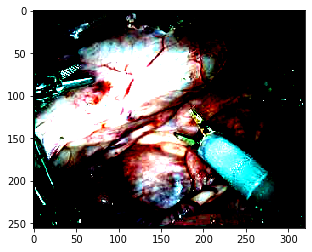

In [48]:
sample = train_dataset.__getitem__(0)
plt.imshow(sample[0].permute(1,2,0))
# plt.imshow(sample[1])

In [0]:
def train_step():
  model.train()
  track_loss = []
  for i,(x,y) in enumerate(train_loader):

    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
      
    y_hat = model(x)
    # compute loss
    loss = loss_func(y_hat,y)
    track_loss.append(loss.item())
    # update
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
  return sum(track_loss)/len(track_loss)

In [0]:
def val_step():
#   model.val()
  track_loss = []
  for i,(x,y) in enumerate(val_loader):

    if torch.cuda.is_available():
      x = x.cuda()
      y = y.cuda()
    
    y_hat = model(x)
    # compute loss
    loss = loss_func(y_hat,y)
    track_loss.append(loss.item())

  return sum(track_loss)/len(track_loss)

In [77]:
torch.cuda.empty_cache()
print("Start Training...")
num_epochs=10
train_loss_store = []
val_loss_store = []
loss_func = DICELoss()

if torch.cuda.is_available():
  loss_func = loss_func.cuda()
  
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # Design your own training section
    time_start = time.time()
    ########################### Training #####################################
    train_loss = train_step()
    train_loss_store.append(train_loss)
    print("Best training loss: ", min(train_loss_store))
    ########################### Validation #####################################
    val_loss = val_step()
    val_loss_store.append(val_loss) 
    print("Best validation loss: ", min(val_loss_store))
    
    time_end = time.time()
    print("Elapsed time for epoch:",time_end - time_start,'s')

Start Training...

EPOCH 1 of 10

Best training loss:  0.6644565085570018
Best validation loss:  0.6673243165016174
Elapsed time for epoch: 29.02326536178589 s

EPOCH 2 of 10

Best training loss:  0.6644565085570018
Best validation loss:  0.6673243165016174
Elapsed time for epoch: 28.932340383529663 s

EPOCH 3 of 10

Best training loss:  0.6644565085570018
Best validation loss:  0.6673243165016174
Elapsed time for epoch: 29.021990299224854 s

EPOCH 4 of 10

Best training loss:  0.6639065384864807
Best validation loss:  0.6655011177062988
Elapsed time for epoch: 29.021849155426025 s

EPOCH 5 of 10

Best training loss:  0.6627870023250579
Best validation loss:  0.6653940916061402
Elapsed time for epoch: 29.02217936515808 s

EPOCH 6 of 10

Best training loss:  0.6627741058667501
Best validation loss:  0.6653936386108399
Elapsed time for epoch: 29.009170293807983 s

EPOCH 7 of 10

Best training loss:  0.6627740522225698
Best validation loss:  0.6653936266899109
Elapsed time for epoch: 28.9

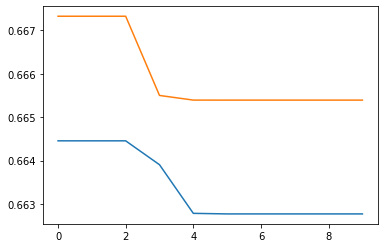

In [78]:
# plotting
steps_store = np.arange(len(train_loss_store))
plt.plot(steps_store,train_loss_store,steps_store,val_loss_store)
#TODO: testing

In [0]:
# PROBLEM 2
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torchvision.datasets import FashionMNIST
import torchvision.models as models

In [0]:
trans = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,),(0.3081,))])


train_dataset = FashionMNIST('/tmp/fmist/', train=True, transform=trans, download=True)
train_images = train_dataset.train_data.numpy().astype(np.float32)
train_labels = train_dataset.train_labels.numpy().astype(np.int)

test_dataset = FashionMNIST('/tmp/fmist/', train=False, transform=trans, download=True)
test_images = test_dataset.test_data.numpy().astype(np.float32)
test_labels = test_dataset.test_labels.numpy().astype(np.int)

In [0]:
model = models.vgg16
loss_func = DICELoss()

print("Start Training...")
num_epochs=1
train_loss_store = []
val_loss_store = []
loss_func = DICELoss()
for epoch in range(num_epochs):
    print("\nEPOCH " +str(epoch+1)+" of "+str(num_epochs)+"\n")
    # Design your own training section
    time_start = time.time()
    ########################### Training #####################################
    train_loss = train_step()
    train_loss_store.extend(train_loss)
    print("Best training loss: ", min(train_loss_store))
    ########################### Validation #####################################
    val_loss = val_step()
    val_loss_store.extend(val_loss) 
    print("Best validation loss: ", min(val_loss_store))
    
    time_end = time.time()
    print("Elapsed time for epoch:",time_end - time_start,'s')
    
# plotting
steps_store = np.arange(len(train_los_store)).tolist
plt.plot(steps_store,train_loss_store,steps_store,val_loss_store)

#TODO: testing